In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
train_dir = '/content/drive/MyDrive/newdatashet1/train'
valid_dir = '/content/drive/MyDrive/newdatashet1/validasi'
test_dir = '/content/drive/MyDrive/newdatashet1/test1'
eval_dir = '/content/drive/MyDrive/newdatashet1/eval'

In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='constant',
    cval=1.0
)

valid_datagen = ImageDataGenerator(rescale=1./255)
eval_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [23]:
print("Memuat data training...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

print("\nMemuat data validasi...")
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

print("\nMemuat data evaluasi...")
eval_generator = eval_datagen.flow_from_directory(
    eval_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("\nMemuat data test...")
test_generator = test_datagen.flow_from_directory(
   test_dir,
    target_size=IMAGE_SIZE,
    batch_size=1,
    class_mode=None,
    shuffle=False,
    classes=[''],
    follow_links=True
)

Memuat data training...
Found 4294 images belonging to 2 classes.

Memuat data validasi...
Found 818 images belonging to 2 classes.

Memuat data evaluasi...
Found 2154 images belonging to 2 classes.

Memuat data test...
Found 2152 images belonging to 1 classes.


In [7]:
def build_model():
    """Membuat arsitektur model deep learning"""
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMAGE_SIZE, 3)
    )

    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model, base_model

In [8]:
model_save_path = '/content/drive/MyDrive/fall_detection_models/'

if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
    print(f"Membuat direktori baru: {model_save_path}")

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=8,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        model_save_path + 'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


In [9]:
print("Membuat model...")
model, base_model = build_model()
model.summary()

Membuat model...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 24,748,545 (94.41 MB)

 Trainable params: 1,182,209 (4.51 MB)

 Non-trainable params: 23,566,336 (89.90 MB)

In [10]:
print("\nMemulai training tahap pertama...")
history1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

print("\nMemulai fine-tuning...")
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Memulai training tahap pertama...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7251 - loss: 0.5852 - precision: 0.8448 - recall: 0.6886
Epoch 1: val_accuracy improved from -inf to 0.87531, saving model to /content/drive/MyDrive/fall_detection_models/best_model.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 684s 5s/step - accuracy: 0.7256 - loss: 0.5842 - precision: 0.8452 - recall: 0.6892 - val_accuracy: 0.8753 - val_loss: 0.3456 - val_precision: 0.8909 - val_recall: 0.9018 - learning_rate: 1.0000e-04
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.8815 - loss: 0.3037 - precision: 0.9304 - recall: 0.8785
Epoch 2: val_accuracy did not improve from 0.87531
135/135 ━━━━━━━━━━━━━━━━━━━━ 98s 690ms/step - accuracy: 0.8816 - loss: 0.3035 - precision: 0.9304 - recall: 0.8786 - val_accuracy: 0.8729 - val_loss: 0.2786 - val_precision: 0.8858 - val_recall: 0.9039 - learning_rate: 1.0000e-04
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.9064 - loss: 0.2428 - precision: 0.9228 - recall: 0.9254

In [11]:
def save_final_model(model, history1, history2):

    final_model_path = model_save_path + 'final_model.keras'
    model.save(final_model_path)
    print(f"\nModel terakhir disimpan di: {final_model_path}")


    history_dict = {
        'history1': history1.history,
        'history2': history2.history
    }
    np.save(model_save_path + 'training_history.npy', history_dict)
    print(f"History training disimpan di: {model_save_path}training_history.npy")

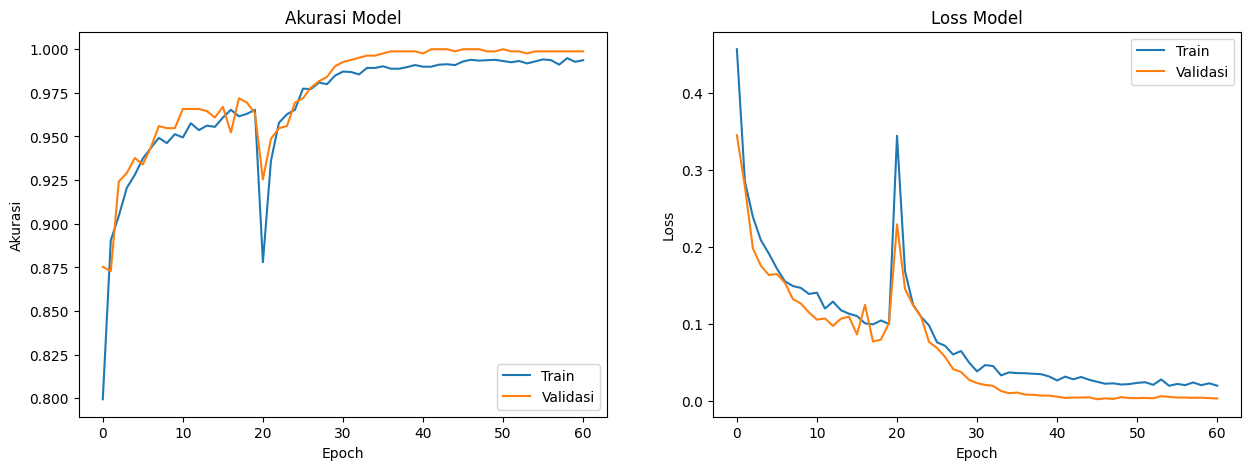


Evaluasi model pada dataset evaluasi...
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 279ms/step - accuracy: 0.9882 - loss: 0.0429 - precision_1: 0.5986 - recall_1: 0.6194
Loss Evaluasi: 0.0306
Akurasi Evaluasi: 0.9916
Presisi Evaluasi: 0.9909
Recall Evaluasi: 0.9954

Model setelah evaluasi disimpan di: /content/drive/MyDrive/fall_detection_models/evaluated_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 302ms/step
Prediksi evaluasi disimpan di: /content/drive/MyDrive/fall_detection_models/evaluation_predictions.csv


In [15]:
def plot_training_history(history1, history2):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'] + history2.history['accuracy'])
    plt.plot(history1.history['val_accuracy'] + history2.history['val_accuracy'])
    plt.title('Akurasi Model')
    plt.ylabel('Akurasi')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validasi'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'] + history2.history['loss'])
    plt.plot(history1.history['val_loss'] + history2.history['val_loss'])
    plt.title('Loss Model')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validasi'], loc='upper right')

    plt.show()

def save_evaluated_model(model, eval_generator):

    evaluated_model_path = model_save_path + 'evaluated_model.keras'
    model.save(evaluated_model_path)
    print(f"\nModel setelah evaluasi disimpan di: {evaluated_model_path}")

    eval_generator.reset()
    eval_predictions = model.predict(eval_generator)
    eval_predicted_classes = (eval_predictions > 0.5).astype(int).flatten()

    eval_data = {
        'id': [os.path.basename(filename) for filename in eval_generator.filenames],
        'true_label': eval_generator.classes,
        'predicted_label': eval_predicted_classes
    }
    eval_df = pd.DataFrame(eval_data)
    eval_df.to_csv(model_save_path + 'evaluation_predictions.csv', index=False)
    print(f"Prediksi evaluasi disimpan di: {model_save_path}evaluation_predictions.csv")

plot_training_history(history1, history2)

print("\nEvaluasi model pada dataset evaluasi...")
eval_generator.reset()
eval_loss, eval_acc, eval_precision, eval_recall = model.evaluate(eval_generator)
print(f'Loss Evaluasi: {eval_loss:.4f}')
print(f'Akurasi Evaluasi: {eval_acc:.4f}')
print(f'Presisi Evaluasi: {eval_precision:.4f}')
print(f'Recall Evaluasi: {eval_recall:.4f}')

save_evaluated_model(model, eval_generator)


68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step


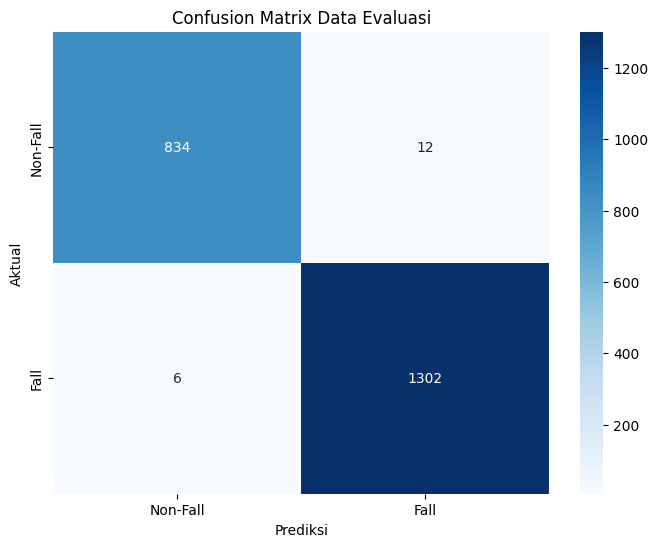


Laporan Klasifikasi:
              precision    recall  f1-score   support

    Non-Fall       0.99      0.99      0.99       846
        Fall       0.99      1.00      0.99      1308

    accuracy                           0.99      2154
   macro avg       0.99      0.99      0.99      2154
weighted avg       0.99      0.99      0.99      2154


Memprediksi data test...
   1/2152 ━━━━━━━━━━━━━━━━━━━━ 1:20 38ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2152/2152 ━━━━━━━━━━━━━━━━━━━━ 533s 248ms/step

File submission telah dibuat!


In [24]:
eval_generator.reset()
eval_predictions = model.predict(eval_generator)
eval_predicted_classes = (eval_predictions > 0.5).astype(int).flatten()

eval_true_classes = eval_generator.classes
plt.figure(figsize=(8, 6))
cm = confusion_matrix(eval_true_classes, eval_predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fall', 'Fall'],
            yticklabels=['Non-Fall', 'Fall'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix Data Evaluasi')
plt.show()

print("\nLaporan Klasifikasi:")
print(classification_report(eval_true_classes, eval_predicted_classes,
                          target_names=['Non-Fall', 'Fall']))

print("\nMemprediksi data test...")
test_generator.reset()
test_predictions = model.predict(test_generator)
test_predicted_classes = (test_predictions > 0.5).astype(int).flatten()

# Membalik label: 1 menjadi 0, dan 0 menjadi 1
test_predicted_classes = 1 - test_predicted_classes

submission_data = {
    'id': [os.path.basename(filename) for filename in test_generator.filenames],
    'label': test_predicted_classes
}
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv('/content/drive/MyDrive/submission_finalok.csv', index=False)
print("\nFile submission telah dibuat!")